<a href="https://colab.research.google.com/github/aayushhyadav/MIA/blob/feature%2Fcifar10/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
import math
import numpy as np
from numpy import trapz
import statistics

In [3]:
'''
  # loads cifar-10 dataset
  # flattens the dataset
  # performs one hot encoding on target values
'''
def load_dataset():
  (train_X, train_y), (test_X, test_y) = tf.keras.datasets.cifar10.load_data()
  train_X, add_test_X, train_y, add_test_y = train_test_split(train_X, train_y, test_size = 0.4, random_state = 42)

  test_X = np.concatenate((test_X, add_test_X))
  test_y = np.concatenate((test_y, add_test_y))

  class_examples_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  class_examples_test = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  
  for example in train_y:
    class_examples_train[example[0]] += 1
  for example in test_y:
    class_examples_test[example[0]] += 1

  for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(train_X[i])
  plt.show()

  print(f'class distribution for training dataset - {class_examples_train}')
  print(f'class distribution for testing dataset - {class_examples_test}')

  ohe_train_y = tf.keras.utils.to_categorical(train_y)
  ohe_test_y = tf.keras.utils.to_categorical(test_y)

  return train_X, test_X, ohe_train_y, ohe_test_y

170498071/170498071 [==============================] - 2s 0us/step


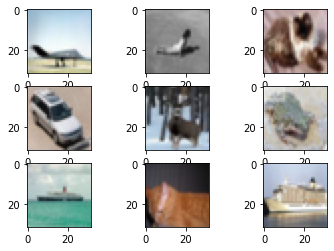

class distribution for training dataset - [3027, 3021, 2991, 2959, 3056, 2967, 3060, 3007, 2955, 2957]
class distribution for testing dataset - [2973, 2979, 3009, 3041, 2944, 3033, 2940, 2993, 3045, 3043]


In [4]:
train_X, test_X, train_y, test_y = load_dataset()

In [5]:
'''
  # perfroms feature scaling on training and test sets
'''
def standardize(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  return train_norm, test_norm

In [6]:
train_norm, test_norm = standardize(train_X, test_X)

In [7]:
'''
  # creates a 2d CNN
'''
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))

  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  
  model.add(tf.keras.layers.Flatten())
  
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [8]:
def create_model_with_reg():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.MaxPool2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.2))
  
  model.add(tf.keras.layers.Flatten())
  
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = create_model()
history = model.fit(train_norm, train_y, epochs = 100, batch_size = 64, validation_data = (test_norm, test_y))

In [12]:
'''
  # plots the loss and accuracy for training and validation sets
'''
def plot_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.set_title('Cross Entropy Loss')
  ax1.plot(history.history['loss'], color = 'blue', label = 'train')
  ax1.plot(history.history['val_loss'], color = 'red', label = 'validation')

  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'], color = 'blue', label = 'train')
  ax2.plot(history.history['val_accuracy'], color = 'red', label = 'validation')

  plt.show()

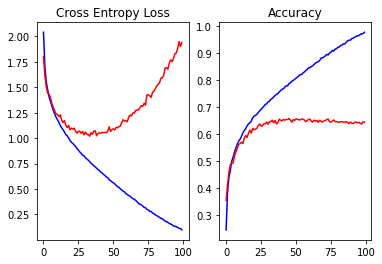

In [9]:
plot_learning_curves(history)

In [10]:
prob_vec_train = model.predict(train_norm)
prob_vec_test = model.predict(test_norm)

938/938 [==============================] - 14s 15ms/step


In [11]:
prob_vec_train[0]

array([9.9999946e-01, 4.5976171e-07, 1.1250818e-09, 1.2192191e-16,
       1.4719429e-14, 2.2147279e-18, 6.8663671e-15, 5.4407865e-22,
       1.0173169e-09, 1.4667436e-11], dtype=float32)

In [1]:
prob_vec_test[0]

NameError: ignored

In [15]:
'''
  # computes entropy for probability vectors
  # prob_vec - probability vector
'''
def cal_entropy(prob_vec):
  entropy = 0
  for prob in prob_vec:
    if(prob != 0):
      entropy += prob * math.log(prob, 10)
  return -1 * entropy

In [16]:
'''
  # computes standard deviation for probability vector
'''
def cal_std(prob_vec):
  mean = statistics.mean(prob_vec)
  variance = 0

  for prob in prob_vec:
    variance += (prob - mean) ** 2
  variance /= len(prob_vec)

  return math.sqrt(variance)

In [17]:
# compute average entropy and standard deviation for probability vector of training examples
# stores the entropy and standard deviation for each probability vector

entropy_train = list()
std_train = list()
max_prob_train = list()

sum_entropy = 0
sum_std = 0
sum_max_prob = 0

for prob_vec in prob_vec_train:
  cur_entropy = cal_entropy(prob_vec)
  cur_std = cal_std(prob_vec)
  cur_max_prob = max(prob_vec)

  entropy_train.append(cur_entropy)
  std_train.append(cur_std)
  max_prob_train.append(cur_max_prob)

  sum_entropy = sum_entropy + cur_entropy
  sum_std = sum_std + cur_std
  sum_max_prob += cur_max_prob

avg_train_entropy = sum_entropy / len(prob_vec_train)
avg_train_std = sum_std / len(prob_vec_train)
avg_train_max_prob = sum_max_prob / len(prob_vec_train)

print(f"Avg train entropy - {avg_train_entropy}, Avg train std - {avg_train_std}, Avg train max probability - {avg_train_max_prob}")

Avg train entropy - 0.914421578501682, Avg train std - 0.05955033590934035, Avg train max probability - 0.22490237708191077


In [18]:
# compute average entropy and standard deviation for probability vector of testing examples
# stores the entropy and standard deviation for each probability vector

entropy_test = list()
std_test = list()
max_prob_test = list()

sum_entropy = 0
sum_std = 0
sum_max_prob = 0

for prob_vec in prob_vec_test:
  cur_entropy = cal_entropy(prob_vec)
  cur_std = cal_std(prob_vec)
  cur_max_prob = max(prob_vec)

  entropy_test.append(cur_entropy)
  std_test.append(cur_std)
  max_prob_test.append(cur_max_prob)

  sum_entropy = sum_entropy + cur_entropy
  sum_std = sum_std + cur_std
  sum_max_prob += cur_max_prob

avg_test_entropy = sum_entropy / len(prob_vec_test)
avg_test_std = sum_std / len(prob_vec_test)
avg_test_max_prob = sum_max_prob / len(prob_vec_test)

print(f"Avg test entropy - {avg_test_entropy}, Avg test std - {avg_test_std}, Avg test max probability - {avg_test_max_prob}")

Avg test entropy - 0.914531065665473, Avg test std - 0.05950480135131761, Avg test max probability - 0.22458663472607732


In [19]:
'''
  # calculates AUC score for attack model using trapezoidal method
  # train_vec - entropy for probability vectors of training examples
  # test_vec - entropy for probability vectors of testing examples
  # pos_count - number of examples which are members of training set
  # neg_count - number of examples which are non-members of training set
  # inc_threshold - controls the number of thresholds for which AUC is computed
'''
def cal_auc(train_vec, test_vec, pos_count, neg_count, inc_threshold = 0.1):
  threshold = 0
  tpr_list, fpr_list = list(), list()
  tuple_tpr, tuple_fpr = list(), list()
  points = list()
  auc = 0

  while(threshold <= 1):
    tp_count = 0
    fp_count = 0

    for val in train_vec:
      if(val >= threshold):
        tp_count += 1
      
    for val in test_vec:
      if(val >= threshold):
        fp_count += 1

    tpr = tp_count / pos_count
    fpr = fp_count / neg_count
    
    tpr_list.append(tpr)
    fpr_list.append(fpr)

    threshold += inc_threshold

  for i in range(len(tpr_list)):
    points.append([fpr_list[i], tpr_list[i]])

  points.sort()

  for i in range(len(points) - 1):
    tuple_tpr.append([points[i][1], points[i + 1][1]])
    tuple_fpr.append([points[i][0], points[i + 1][0]])

  auc = sum(np.trapz(tuple_tpr, tuple_fpr))

  plt.scatter(fpr_list, tpr_list)
  plt.show()
  
  return auc

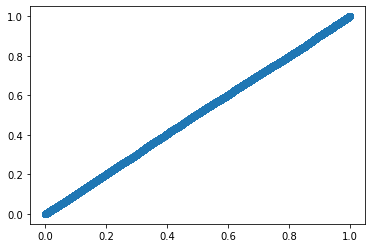

0.5008997794444466

In [20]:
# calculate auc score using entropy as the parameter
cal_auc(entropy_train, entropy_test, len(entropy_train), len(entropy_test), 0.00001)

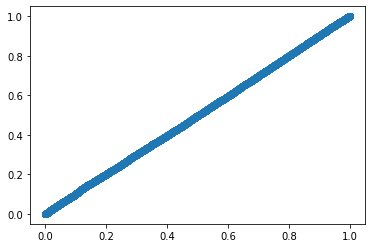

0.49917971499999986

In [21]:
# calculate auc score using standard deviation as the parameter
cal_auc(std_train, std_test, len(std_train), len(std_test), 0.00001)

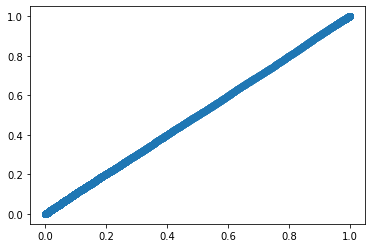

0.5000883327777773

In [22]:
# calculate auc score using max probability as the parameter
cal_auc(max_prob_train, max_prob_test, len(max_prob_train), len(max_prob_test), 0.0001)

In [10]:
reg_model = create_model_with_reg()
history = reg_model.fit(train_norm, train_y, epochs = 100, batch_size = 64, validation_data = (test_norm, test_y))

Epoch 1/100
469/469 [==============================] - 60s 127ms/step - loss: 2.1135 - accuracy: 0.2116 - val_loss: 1.8784 - val_accuracy: 0.3335
Epoch 2/100
469/469 [==============================] - 57s 121ms/step - loss: 1.8537 - accuracy: 0.3163 - val_loss: 1.7197 - val_accuracy: 0.3874
Epoch 3/100
469/469 [==============================] - 57s 122ms/step - loss: 1.7412 - accuracy: 0.3542 - val_loss: 1.6202 - val_accuracy: 0.4168
Epoch 4/100
469/469 [==============================] - 59s 125ms/step - loss: 1.6595 - accuracy: 0.3860 - val_loss: 1.5605 - val_accuracy: 0.4426
Epoch 5/100
469/469 [==============================] - 57s 123ms/step - loss: 1.6012 - accuracy: 0.4079 - val_loss: 1.5028 - val_accuracy: 0.4610
Epoch 6/100
469/469 [==============================] - 58s 124ms/step - loss: 1.5526 - accuracy: 0.4302 - val_loss: 1.4535 - val_accuracy: 0.4714
Epoch 7/100
469/469 [==============================] - 59s 125ms/step - loss: 1.5149 - accuracy: 0.4378 - val_loss: 1.4463 -

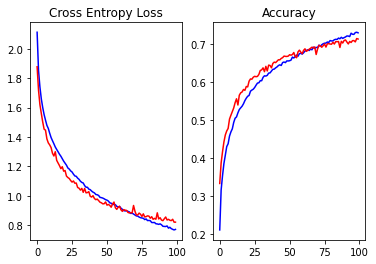

In [13]:
plot_learning_curves(history)

In [14]:
prob_vec_train = model.predict(train_norm)
prob_vec_test = model.predict(test_norm)

938/938 [==============================] - 16s 17ms/step
